In [31]:
# Data management
# ------------------------------------------------------------------------------
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd

# Graphics
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt

# Preprocessing and modelling
# evaluate bagging ensemble for regression
# ------------------------------------------------------------------------------
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing

from sklearn import metrics
from sklearn.metrics import mean_squared_error






# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
#warnings.filterwarnings('once')
warnings.filterwarnings('ignore')

In [32]:
# Data Loading


#training data
data_train = pd.read_excel("housing.xlsx", sheet_name='Hoja1')
data_train.head()



,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2310.0,0,0.538,65750,65.2,40900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7070.0,0,0.469,64210,78.9,49671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7070.0,0,0.469,71850,61.1,49671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2180.0,0,0.458,69980,45.8,60622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2180.0,0,0.458,71470,54.2,60622,3,222.0,18.7,396.90,5.33,36.2


In [33]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    int64  
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    int64  
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(10), int64(4)
memory usage: 55.5 KB


In [34]:
# Configuring train and test datasets
# ------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
                                        data_train.drop(columns = "MEDV"),
                                        data_train['MEDV'],
                                        random_state = 123
                                    )


In [35]:
#I- GradientBoosting

# Model creation
# ==============================================================================
model = GradientBoostingRegressor(
            n_estimators = 10,
            loss         = 'ls',
            max_features = 'auto',
            random_state = 123
         )

# Model trainingEntrenamiento del modelo
# ==============================================================================
model.fit(X_train, y_train)

GradientBoostingRegressor(loss='ls', max_features='auto', n_estimators=10,
                          random_state=123)

In [36]:
# Model training error
#-------------------------------------------------------------------------------
prediction_train = model.predict(X = X_train)


#Measuring Goodness of fit in Training data

print('R2 Value in training:', round(metrics.r2_score(y_train, prediction_train),2))

#Measuring accuracy on Testing Data
print('Accuracy in training',round( 100- (np.mean(np.abs((y_train - prediction_train) / y_train)) * 100), 2))
      
 
residuals_train=y_train - prediction_train


rmse = mean_squared_error(
        y_true  = y_train,
        y_pred  = prediction_train,
        squared = False
       )
print(f"RMSE in train: {rmse}")

R2 Value in training: 0.77
Accuracy in training 81.15
RMSE in train: 4.428356880517048


In [37]:
# Model test error
#-------------------------------------------------------------------------------
prediction_test = model.predict(X = X_test)


#Measuring accuracy on Testing Data
print('Accuracy in test',round( 100- (np.mean(np.abs((y_test - prediction_test) / y_test)) * 100), 2))
      
 
residuals_testn=y_test - prediction_test

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = prediction_test,
        squared = False
       )
print(f"RMSE in test: {rmse}")

Accuracy in test 81.88
RMSE in test: 4.845573775275982


Valor óptimo de n_estimators: 151


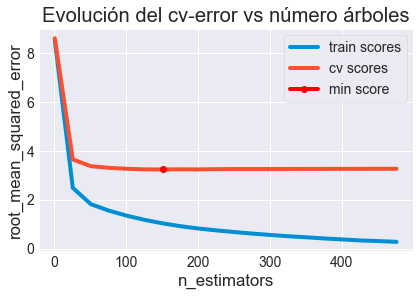

In [38]:
# the number of trees is searched based on k-cross-validation & least squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
estimator_range = range(1, 500, 25)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:
    
    modelo = GradientBoostingRegressor(
                n_estimators = n_estimators,
                loss         = 'ls',
                max_features = 'auto',
                random_state = 123
             )
    
    # Error de train
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X = X_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5,
                n_jobs    = multiprocessing.cpu_count() - 1,
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")

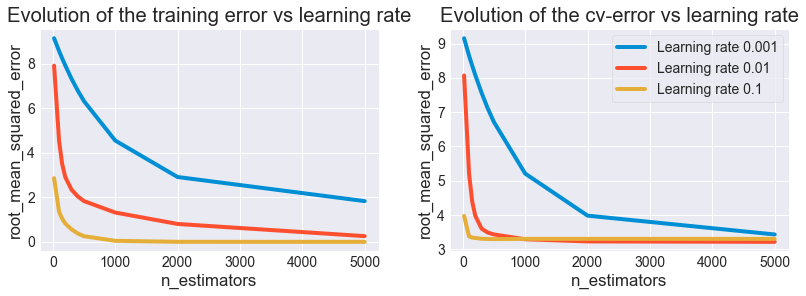

In [39]:
# Learning rate is tested based on k-cross-validation & neg_root_mean_squared_error
# ==============================================================================
results = {}

# Values tested
learning_rates = [0.001, 0.01, 0.1]
n_estimators   = [20, 100, 150, 200, 300, 400, 500, 1000, 2000, 5000]


# Loop for trining the model trying combinations of  learning_rate & n_estimator 
# Obtaining training error & k-cross-validation error.
for learning_rate in learning_rates:
    train_scores = []
    cv_scores    = []
    
    for n_estimator in n_estimators:
    
        model = GradientBoostingRegressor(
                    n_estimators  = n_estimator,
                    learning_rate = learning_rate,
                    loss          = 'ls',
                    max_features  = 'auto',
                    random_state  = 123
                 )

        # Error de train
        model.fit(X_train, y_train)
        predictions = model.predict(X = X_train)
        rmse = mean_squared_error(
                y_true  = y_train,
                y_pred  = predictions,
                squared = False
               )
        train_scores.append(rmse)

        # Error of CV
        scores = cross_val_score(
                    estimator = model,
                    X         = X_train,
                    y         = y_train,
                    scoring   = 'neg_root_mean_squared_error',
                    cv        = 3,
                    n_jobs    = multiprocessing.cpu_count() - 1
                 )
        # Aggregating scores of cross_val_score() and changing sign to positive
        cv_scores.append(-1*scores.mean())
        
    results[learning_rate] = {'train_scores': train_scores, 'cv_scores': cv_scores}

# Graphic presenting the error evolution
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 3.84))

for key, value in results.items():
    axs[0].plot(n_estimators, value['train_scores'], label=f"Learning rate {key}")
    axs[0].set_ylabel("root_mean_squared_error")
    axs[0].set_xlabel("n_estimators")
    axs[0].set_title("Evolution of the training error vs learning rate")
    
    axs[1].plot(n_estimators, value['cv_scores'], label=f"Learning rate {key}")
    axs[1].set_ylabel("root_mean_squared_error")
    axs[1].set_xlabel("n_estimators")
    axs[1].set_title("Evolution of the cv-error vs learning rate")
    plt.legend();

Optimum value of max_depth: 3


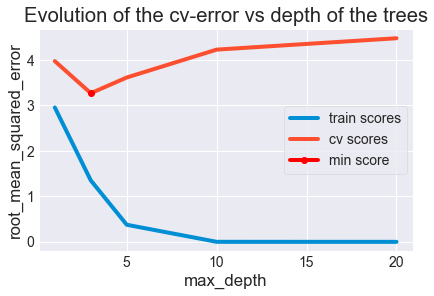

In [40]:
# Searching max-depth using k-cross-validation & neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Values tested
max_depths = [1, 3, 5, 10, 20]

# Loop for training the model for each valie in max_depth & obtining the training error
# and the k-cross-validation error.
for max_depth in max_depths:
    
    model = GradientBoostingRegressor(
                n_estimators = 100,
                loss         = 'ls',
                max_depth    = max_depth,
                max_features = 'auto',
                random_state = 123
             )
    
    # Training error
    model.fit(X_train, y_train)
    predictions = model.predict(X = X_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predictions,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error of CV
    scores = cross_val_score(
                estimator = model,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5,
                n_jobs    = multiprocessing.cpu_count() - 1
             )
    # Aggregation of scores of cross_val_score() and changing the sign
    cv_scores.append(-1*scores.mean())
    
# Graphic showing the error evolution
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_depths, train_scores, label="train scores")
ax.plot(max_depths, cv_scores, label="cv scores")
ax.plot(max_depths[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_depth")
ax.set_title("Evolution of the cv-error vs depth of the trees")
plt.legend();
print(f"Optimum value of max_depth: {max_depths[np.argmin(cv_scores)]}")

In [41]:
# Grid Seach based on CV

from sklearn.model_selection import ParameterGrid

# Grid of hiperparameters evaluated
# ==============================================================================
param_grid = {'max_features'  : ['auto', 'sqrt', 'log2'],
              'max_depth'     : [None, 1, 3, 5, 10, 20],
              'subsample'     : [0.5, 1],
              'learning_rate' : [0.001, 0.01, 0.1]
             }

# Gris search by CV
# ==============================================================================
grid = GridSearchCV(
        estimator  = GradientBoostingRegressor(
                        n_estimators        = 1000, 
                        random_state        = 123,
                        # Activation of early stop
                        validation_fraction = 0.1,
                        n_iter_no_change    = 5,
                        tol                 = 0.0001
                    ),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
results = pd.DataFrame(grid.cv_results_)
results.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(10)

,param_learning_rate,param_max_depth,param_max_features,param_subsample,mean_test_score,std_test_score,mean_train_score,std_train_score
39,0.01,None,sqrt,1,-3.472725,0.602239,-0.998344,0.167062
41,0.01,None,log2,1,-3.472725,0.602239,-0.998344,0.167062
63,0.01,10,sqrt,1,-3.476091,0.596637,-0.968710,0.147730
65,0.01,10,log2,1,-3.476091,0.596637,-0.968710,0.147730
69,0.01,20,sqrt,1,-3.479620,0.588686,-0.984109,0.148883
71,0.01,20,log2,1,-3.479620,0.588686,-0.984109,0.148883
57,0.01,5,sqrt,1,-3.530687,0.646351,-1.457298,0.118480
59,0.01,5,log2,1,-3.530687,0.646351,-1.457298,0.118480
62,0.01,10,sqrt,0.5,-3.532153,0.437392,-1.589865,0.492752
64,0.01,10,log2,0.5,-3.532153,0.437392,-1.589865,0.492752


In [42]:
# Best hiperparameters using CV
# ==============================================================================
print("----------------------------------------")
print("Best hiperparameters found (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Best hiperparameters found (cv)
----------------------------------------
{'learning_rate': 0.01, 'max_depth': None, 'max_features': 'sqrt', 'subsample': 1} : -3.4727252201547976 neg_root_mean_squared_error


In [43]:
# Although it has been indicated that n_estimator = 1000, due to the activation of 
# the early stop, the training may have stopped earlier.

# Number of trees of the final model (early stopping activated)
# ==============================================================================
print(f"Number of trees of the final model: {grid.best_estimator_.n_estimators_}")

Number of trees of the final model: 781


In [44]:
# Selecting Best model
model_final = grid.best_estimator_

In [45]:
# Final Model training error
#-------------------------------------------------------------------------------
prediction_train = model_final.predict(X = X_train)


#Measuring Goodness of fit in Training data

print('R2 Value in training:', round(metrics.r2_score(y_train, prediction_train),2))

#Measuring accuracy on Testing Data
print('Accuracy in training',round( 100- (np.mean(np.abs((y_train - prediction_train) / y_train)) * 100), 2))
      
 
residuals_train=y_train - prediction_train


rmse = mean_squared_error(
        y_true  = y_train,
        y_pred  = prediction_train,
        squared = False
       )
print(f"RMSE in train: {rmse}")

R2 Value in training: 0.99
Accuracy in training 99.0
RMSE in train: 1.007348949204823


In [46]:
# Model test error
#-------------------------------------------------------------------------------
prediction_test = model_final.predict(X = X_test)


#Measuring accuracy on Testing Data
print('Accuracy in test',round( 100- (np.mean(np.abs((y_test - prediction_test) / y_test)) * 100), 2))
      
 
residuals_testn=y_test - prediction_test

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = prediction_test,
        squared = False
       )
print(f"RMSE in test: {rmse}")

Accuracy in test 89.95
RMSE in test: 3.3137845449761794


In [47]:
importance_predictors = pd.DataFrame(
                            {'predictor': data_train.drop(columns = "MEDV").columns,
                             'importance': model_final.feature_importances_}
                            )
print("Importance of the model predictors")
print("-------------------------------------------")
importance_predictors.sort_values('importance', ascending=False)

Importance of the model predictors
-------------------------------------------


,predictor,importance
5,RM,0.285641
12,LSTAT,0.228309
10,PTRATIO,0.085984
2,INDUS,0.077056
0,CRIM,0.070531
4,NOX,0.070263
7,DIS,0.057169
9,TAX,0.050185
6,AGE,0.026356
11,B,0.023320


In [48]:
from sklearn.inspection import permutation_importance

importance_per = permutation_importance(
                estimator    = model_final,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importance = pd.DataFrame(
                    {k: importance_per[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importance['feature'] = X_train.columns
df_importance.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
12,4.495778,0.186956,LSTAT
5,3.970350,0.071614,RM
4,1.359544,0.083017,NOX
10,1.054011,0.058822,PTRATIO
0,1.022468,0.030199,CRIM
7,0.942680,0.042429,DIS
2,0.774282,0.042071,INDUS
9,0.643033,0.028235,TAX
6,0.391051,0.022505,AGE
11,0.259365,0.019620,B


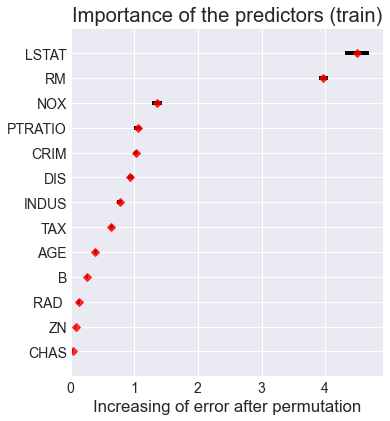

In [49]:
# Graphic
fig, ax = plt.subplots(figsize=(5, 6))
df_importance = df_importance.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importance['feature'],
    df_importance['importances_mean'],
    xerr=df_importance['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importance['importances_mean'],
    df_importance['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importance of the predictors (train)')
ax.set_xlabel('Increasing of error after permutation');

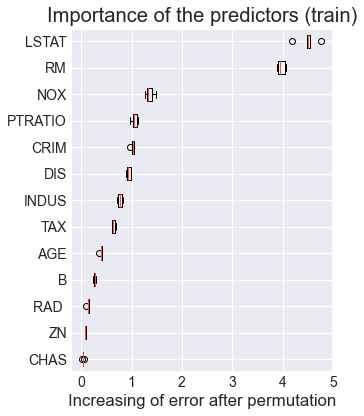

In [50]:
# Graphic Alternative
fig, ax = plt.subplots(figsize=(5, 6))
sorted_idx = importance_per.importances_mean.argsort()
ax.boxplot(
        importance_per.importances[sorted_idx].T,
        vert   = False,
        labels = data_train.drop(columns = "MEDV").columns[sorted_idx]
)
ax.set_title('Importance of the predictors (train)')
ax.set_xlabel('Increasing of error after permutation');
fig.tight_layout();

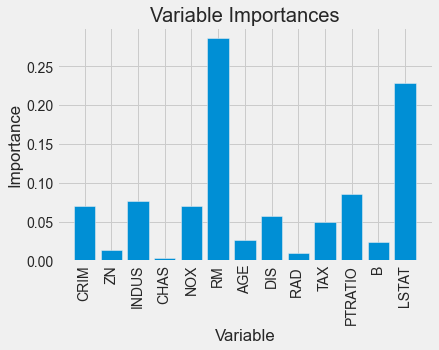

In [51]:
importances= model_final.feature_importances_
feature_list = data_train.drop(columns = "MEDV").columns

%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

<AxesSubplot:xlabel='MEDV', ylabel='Density'>

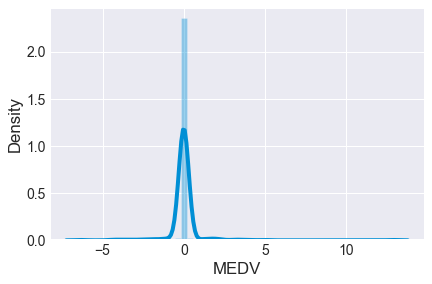

In [52]:
# Error in training
import seaborn as sns
sns.set_style('darkgrid')
sns.distplot(y_train-prediction_train)

<AxesSubplot:xlabel='MEDV', ylabel='Density'>

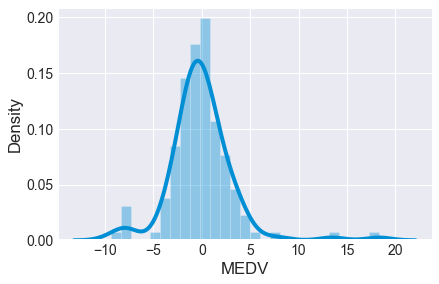

In [53]:
# Error in test

sns.set_style('darkgrid')
sns.distplot(y_test-prediction_test)

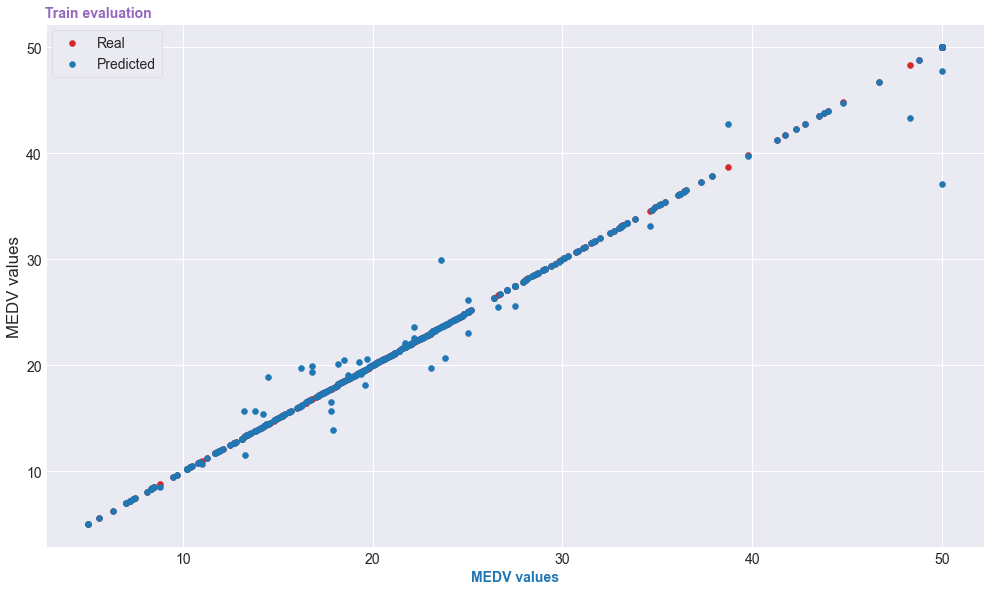

In [54]:
import matplotlib.pyplot as plt  # TRAINING

fig, ax = plt.subplots(figsize=(15, 9))


#x_axis=list(range(len(y_train)))

ax.scatter(y_train, y_train, color = 'tab:red', label='Real')
ax.scatter(y_train, prediction_train, color = 'tab:blue', label='Predicted')
ax.set_xlabel("MEDV values", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("MEDV values")
ax.set_title('Train evaluation', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

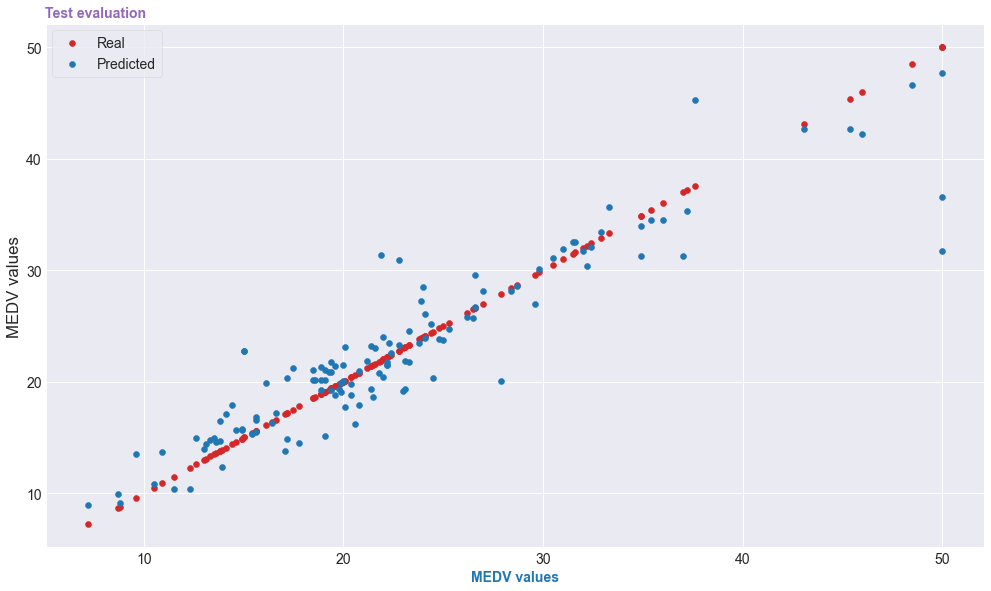

In [55]:
#######  TEST

fig, ax = plt.subplots(figsize=(15, 9))


#x_axis=list(range(len(y_train)))

ax.scatter(y_test, y_test, color = 'tab:red', label='Real')
ax.scatter(y_test, prediction_test, color = 'tab:blue', label='Predicted')
ax.set_xlabel("MEDV values", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("MEDV values")
ax.set_title('Test evaluation', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

In [56]:
# Model based on XGBoost:
# - Allows observations to include missing values
# - Allows the use of GPUs
# - Parallelized training (parallelizes some parts of the algorithm)
# - Allow monotonic constraints
# - Allows working on sparse matrices
# - Required one-hot-encoding of categorical variables

In [57]:
# Instalación XGBoost: conda install -c conda-forge xgboost
from xgboost import XGBRegressor

In [58]:
# Grid of the hipermarameters to evaluate
# ==============================================================================
param_grid = {'max_depth'        : [None, 1, 3, 5, 10, 20],
              'subsample'        : [0.5, 1],
              'learning_rate'    : [0.001, 0.01, 0.1],
              'booster'          : ['gbtree']
             }


# Creation of a validation dataset
# ==============================================================================
np.random.seed(123)
idx_validacion = np.random.choice(
                    X_train.shape[0],
                    size= int(X_train.shape[0]*0.1),
                    replace=False
                 )

X_val = X_train.iloc[idx_validacion, :].copy()
y_val = y_train.iloc[idx_validacion].copy()

X_train_grid = X_train.reset_index(drop = True).drop(idx_validacion, axis = 0).copy()
y_train_grid = y_train.reset_index(drop = True).drop(idx_validacion, axis = 0).copy()

# XGBoost requires to pass the specific parameters for training calling the methodd .fit()
fit_params = {"early_stopping_rounds" : 5, 
              "eval_metric"           : "rmse", 
              "eval_set"              : [(X_val, y_val)],
              "verbose"               : 0
             }

# grid search with CV
# ==============================================================================
grid = GridSearchCV(
        estimator  = XGBRegressor(
                        n_estimators = 1000,
                        random_state = 123
                    ),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train_grid, y = y_train_grid, **fit_params)

# Results
# ==============================================================================
results = pd.DataFrame(grid.cv_results_)
results.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(10)

,param_booster,param_learning_rate,param_max_depth,param_subsample,mean_test_score,std_test_score,mean_train_score,std_train_score
20,gbtree,0.01,10,0.5,-3.550098,0.853452,-1.225759,0.281986
28,gbtree,0.1,3,0.5,-3.557241,0.749096,-2.021208,0.490586
22,gbtree,0.01,20,0.5,-3.563934,0.856871,-1.231614,0.278596
32,gbtree,0.1,10,0.5,-3.574578,0.819325,-0.947114,0.048410
18,gbtree,0.01,5,0.5,-3.595936,0.817428,-1.656739,0.429067
12,gbtree,0.01,None,0.5,-3.605919,0.772592,-1.602223,0.654931
30,gbtree,0.1,5,0.5,-3.608567,0.772382,-1.391107,0.314252
24,gbtree,0.1,None,0.5,-3.610089,0.834111,-1.354761,0.039584
34,gbtree,0.1,20,0.5,-3.630277,0.854677,-1.311019,0.087407
16,gbtree,0.01,3,0.5,-3.685421,0.802731,-2.219238,0.248449


In [59]:
# Best hiperparameters using CV
# ==============================================================================
print("----------------------------------------")
print("Best hiperparameters found (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Best hiperparameters found (cv)
----------------------------------------
{'booster': 'gbtree', 'learning_rate': 0.01, 'max_depth': 10, 'subsample': 0.5} : -3.5500975847743566 neg_root_mean_squared_error


In [60]:
# Number of trees of the final model (early stopping activated)
# ==============================================================================
n_trees_included = len(grid.best_estimator_.get_booster().get_dump())
print(f"Number of trees included in the model: {n_trees_included}")

Number of trees included in the model: 418


In [61]:
from sklearn.inspection import permutation_importance

importance_per = permutation_importance(
                estimator    = model_final,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importance = pd.DataFrame(
                    {k: importance_per[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importance['feature'] = X_train.columns
df_importance.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
12,4.495778,0.186956,LSTAT
5,3.970350,0.071614,RM
4,1.359544,0.083017,NOX
10,1.054011,0.058822,PTRATIO
0,1.022468,0.030199,CRIM
7,0.942680,0.042429,DIS
2,0.774282,0.042071,INDUS
9,0.643033,0.028235,TAX
6,0.391051,0.022505,AGE
11,0.259365,0.019620,B


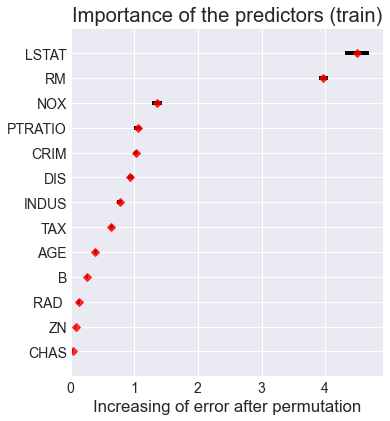

In [62]:
# Graphic
fig, ax = plt.subplots(figsize=(5, 6))
df_importance = df_importance.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importance['feature'],
    df_importance['importances_mean'],
    xerr=df_importance['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importance['importances_mean'],
    df_importance['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importance of the predictors (train)')
ax.set_xlabel('Increasing of error after permutation');

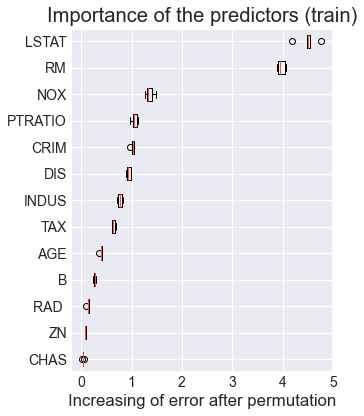

In [63]:
# Graphic Alternative
fig, ax = plt.subplots(figsize=(5, 6))
sorted_idx = importance_per.importances_mean.argsort()
ax.boxplot(
        importance_per.importances[sorted_idx].T,
        vert   = False,
        labels = data_train.drop(columns = "MEDV").columns[sorted_idx]
)
ax.set_title('Importance of the predictors (train)')
ax.set_xlabel('Increasing of error after permutation');
fig.tight_layout();

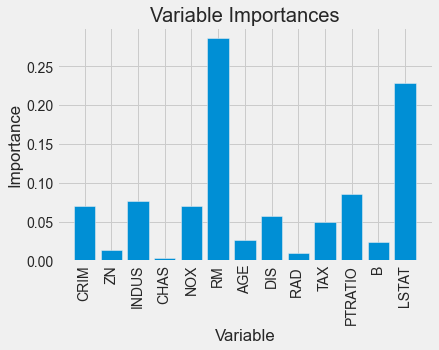

In [64]:
importances= model_final.feature_importances_
feature_list = data_train.drop(columns = "MEDV").columns

%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [81]:
# Selecting Best model
model_xgb = grid.best_estimator_

In [82]:
# Alternatively 
# create an xgboost regression model
#model_xgb = XGBRegressor(n_estimators=418, max_depth=10, eta=0.1, subsample=0.5, learning_rate= 0.01)
# Entrenamiento del modelo
# ==============================================================================
#model_xgb.fit(X_train, y_train)

In [83]:
# Final Model training error
#-------------------------------------------------------------------------------
prediction_train = model_xgb.predict(X = X_train)


#Measuring Goodness of fit in Training data

print('R2 Value in training:', round(metrics.r2_score(y_train, prediction_train),2))

#Measuring accuracy on Testing Data
print('Accuracy in training',round( 100- (np.mean(np.abs((y_train - prediction_train) / y_train)) * 100), 2))
      
 
residuals_train=y_train - prediction_train


rmse = mean_squared_error(
        y_true  = y_train,
        y_pred  = prediction_train,
        squared = False
       )
print(f"RMSE in train: {rmse}")

R2 Value in training: 0.96
Accuracy in training 94.38
RMSE in train: 1.8172563460512094


In [84]:
# Model test error
#-------------------------------------------------------------------------------
prediction_test = model_xgb.predict(X = X_test)


#Measuring accuracy on Testing Data
print('Accuracy in test',round( 100- (np.mean(np.abs((y_test - prediction_test) / y_test)) * 100), 2))
      
 
residuals_testn=y_test - prediction_test

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = prediction_test,
        squared = False
       )
print(f"RMSE in test: {rmse}")

Accuracy in test 88.08
RMSE in test: 4.1558350534067445


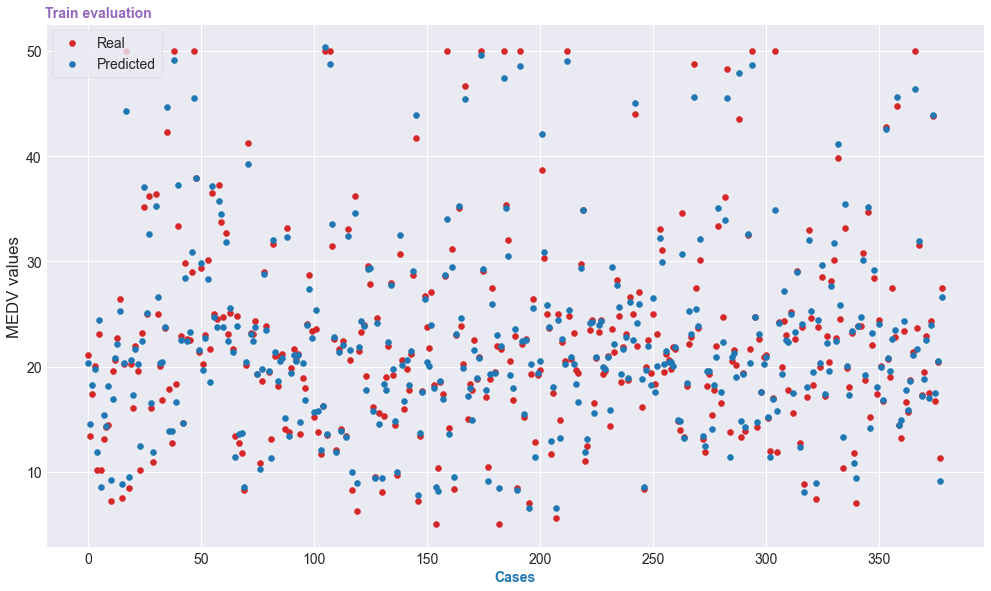

In [85]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 9))


x_axis=list(range(len(y_train)))

ax.scatter(x_axis, y_train, color = 'tab:red', label='Real')
ax.scatter(x_axis, prediction_train, color = 'tab:blue', label='Predicted')
ax.set_xlabel("Cases", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("MEDV values")
ax.set_title('Train evaluation', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

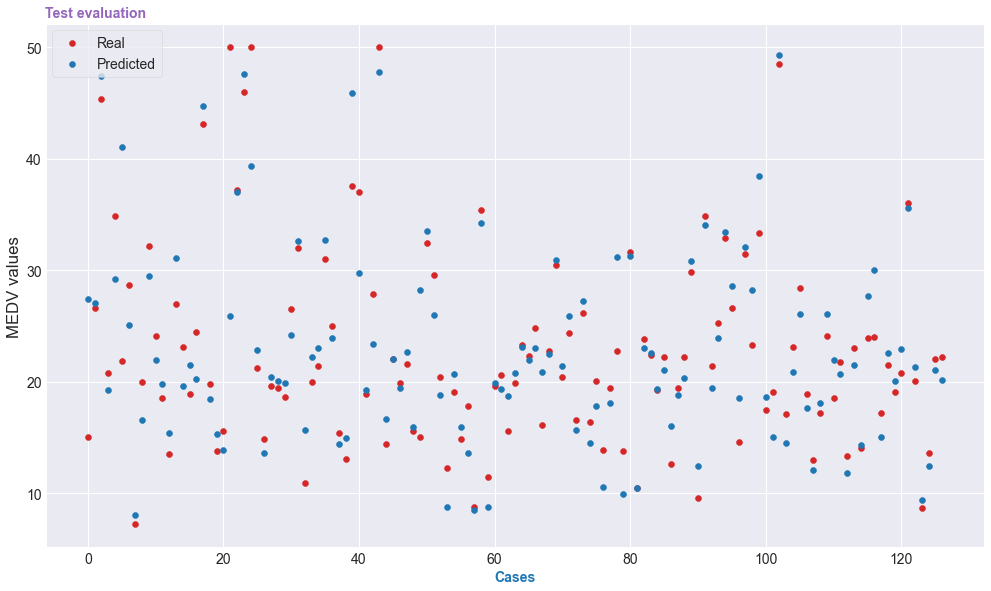

In [86]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 9))


x_axis=list(range(len(y_test)))

ax.scatter(x_axis, y_test, color = 'tab:red', label='Real')
ax.scatter(x_axis, prediction_test, color = 'tab:blue', label='Predicted')
ax.set_xlabel("Cases", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("MEDV values")
ax.set_title('Test evaluation', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

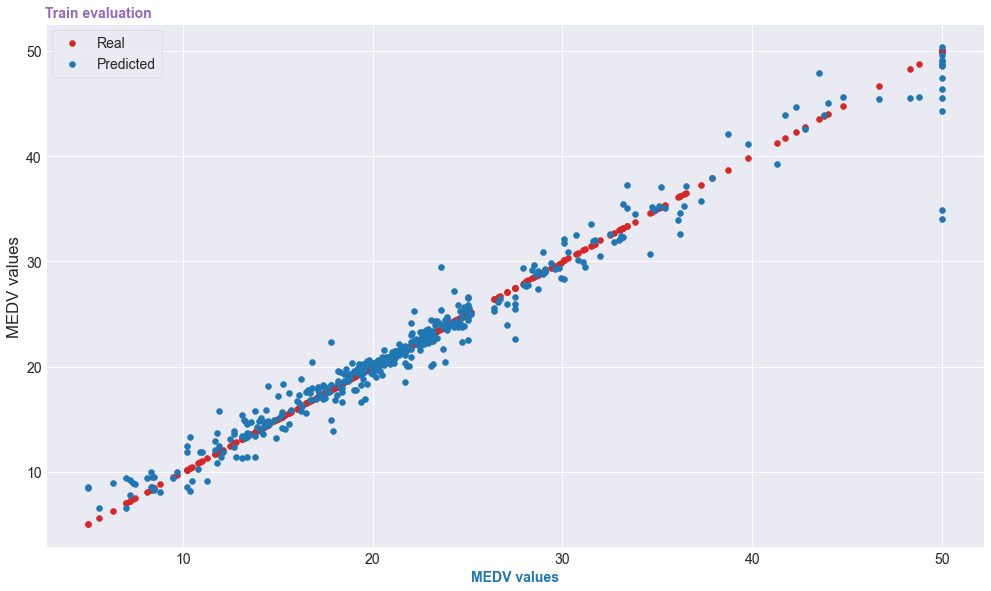

In [87]:
import matplotlib.pyplot as plt  # TRAINING

fig, ax = plt.subplots(figsize=(15, 9))


#x_axis=list(range(len(y_train)))

ax.scatter(y_train, y_train, color = 'tab:red', label='Real')
ax.scatter(y_train, prediction_train, color = 'tab:blue', label='Predicted')
ax.set_xlabel("MEDV values", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("MEDV values")
ax.set_title('Train evaluation', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

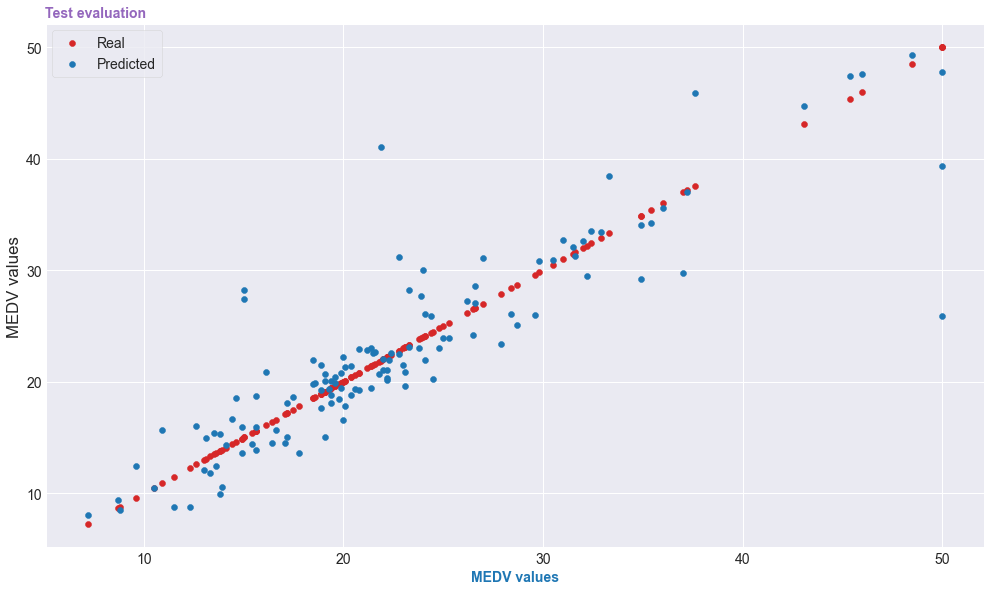

In [88]:
#######  TEST

fig, ax = plt.subplots(figsize=(15, 9))


#x_axis=list(range(len(y_train)))

ax.scatter(y_test, y_test, color = 'tab:red', label='Real')
ax.scatter(y_test, prediction_test, color = 'tab:blue', label='Predicted')
ax.set_xlabel("MEDV values", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("MEDV values")
ax.set_title('Test evaluation', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

<AxesSubplot:xlabel='MEDV', ylabel='Density'>

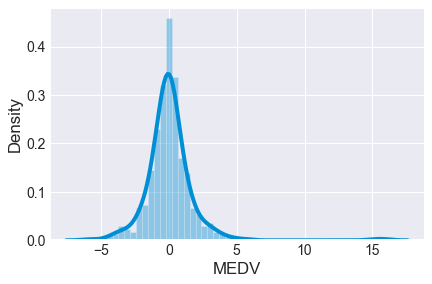

In [89]:
# Error in training
import seaborn as sns
sns.set_style('darkgrid')
sns.distplot(y_train-prediction_train)

<AxesSubplot:xlabel='MEDV', ylabel='Density'>

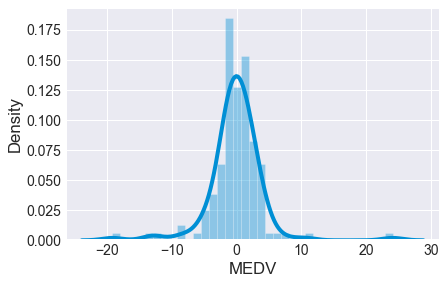

In [90]:
# Error in test

sns.set_style('darkgrid')
sns.distplot(y_test-prediction_test)

In [91]:
# Model based on LightGBM
# - Allows observations to include missing values
# - Allows the use of GPUs
# - Parallelized training (parallelizes some parts of the algorithm)
# - Allow monotonic constraints
# - Allows working on sparse matrices
# - No need for one-hot-encoding of categorical variables


In [92]:
# Installation LightGBM: conda install -c conda-forge lightgbm
from lightgbm.sklearn import LGBMRegressor

In [93]:
# Grid of hiperparameters to evaluate 
# ==============================================================================
param_grid = {'n_estimators'     : [100, 500, 1000, 5000],
              'max_depth'        : [-1, 1, 3, 5, 10, 20],
              'subsample'        : [0.5, 1],
              'learning_rate'    : [0.001, 0.01, 0.1],
              'boosting_type'    : ['gbdt']
             }

# grid search with CV
# ==============================================================================
grid = GridSearchCV(
        estimator  = LGBMRegressor(random_state=123),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train_grid, y = y_train_grid)

# Resultados
# ==============================================================================
results = pd.DataFrame(grid.cv_results_)
results.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_boosting_type,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,mean_test_score,std_test_score,mean_train_score,std_train_score
93,gbdt,0.01,20,1000,1,-3.780533,0.784177,-1.75351,0.179338
53,gbdt,0.01,-1,1000,1,-3.780533,0.784177,-1.75351,0.179338
52,gbdt,0.01,-1,1000,0.5,-3.780533,0.784177,-1.75351,0.179338
84,gbdt,0.01,10,1000,0.5,-3.780533,0.784177,-1.75351,0.179338


In [94]:
# Best hiperparameters using CV
# ==============================================================================
print("----------------------------------------")
print("Best hiperparameters found (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Best hiperparameters found (cv)
----------------------------------------
{'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 1000, 'subsample': 0.5} : -3.780532658658755 neg_root_mean_squared_error


In [95]:
# Selecting Best model
model_light_final = grid.best_estimator_

In [96]:
# Final Model training error
#-------------------------------------------------------------------------------
prediction_train = model_light_final.predict(X = X_train)


#Measuring Goodness of fit in Training data

print('R2 Value in training:', round(metrics.r2_score(y_train, prediction_train),2))

#Measuring accuracy on Testing Data
print('Accuracy in training',round( 100- (np.mean(np.abs((y_train - prediction_train) / y_train)) * 100), 2))
      
 
residuals_train=y_train - prediction_train


rmse = mean_squared_error(
        y_true  = y_train,
        y_pred  = prediction_train,
        squared = False
       )
print(f"RMSE in train: {rmse}")

R2 Value in training: 0.96
Accuracy in training 94.38
RMSE in train: 1.8172563460512094


In [97]:
# Model test error
#-------------------------------------------------------------------------------
prediction_test = model_light_final.predict(X = X_test)


#Measuring accuracy on Testing Data
print('Accuracy in test',round( 100- (np.mean(np.abs((y_test - prediction_test) / y_test)) * 100), 2))
      
 
residuals_testn=y_test - prediction_test

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = prediction_test,
        squared = False
       )
print(f"RMSE in test: {rmse}")

Accuracy in test 88.08
RMSE in test: 4.1558350534067445


In [98]:
importance_predictors = pd.DataFrame(
                            {'predictor': data_train.drop(columns = "MEDV").columns,
                             'importance': model_light_final.feature_importances_}
                            )
print("Importance of the model predictors")
print("-------------------------------------------")
importance_predictors.sort_values('importance', ascending=False)

Importance of the model predictors
-------------------------------------------


,predictor,importance
12,LSTAT,1958
6,AGE,1949
7,DIS,1824
5,RM,1639
0,CRIM,1055
4,NOX,979
10,PTRATIO,811
11,B,755
9,TAX,695
2,INDUS,411


In [99]:
from sklearn.inspection import permutation_importance

importance_per = permutation_importance(
                estimator    = model_light_final,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importance = pd.DataFrame(
                    {k: importance_per[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importance['feature'] = X_train.columns
df_importance.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
5,5.227310,0.168130,RM
12,5.168808,0.250278,LSTAT
7,1.090332,0.102552,DIS
4,0.924262,0.059372,NOX
6,0.624062,0.067877,AGE
0,0.597359,0.034756,CRIM
10,0.576124,0.054712,PTRATIO
9,0.331452,0.032984,TAX
8,0.172095,0.016663,RAD
11,0.117233,0.012933,B


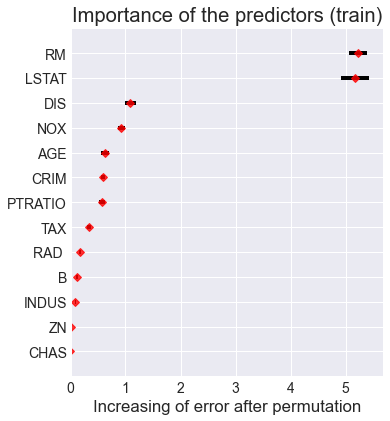

In [100]:
# Graphic
fig, ax = plt.subplots(figsize=(5, 6))
df_importance = df_importance.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importance['feature'],
    df_importance['importances_mean'],
    xerr=df_importance['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importance['importances_mean'],
    df_importance['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importance of the predictors (train)')
ax.set_xlabel('Increasing of error after permutation');

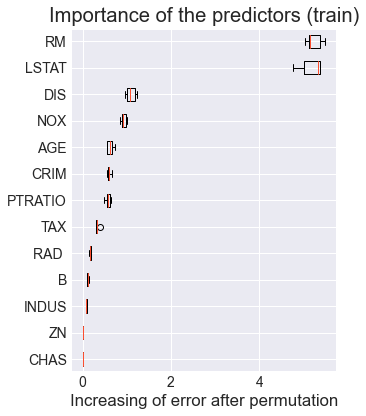

In [101]:
# Graphic Alternative
fig, ax = plt.subplots(figsize=(5, 6))
sorted_idx = importance_per.importances_mean.argsort()
ax.boxplot(
        importance_per.importances[sorted_idx].T,
        vert   = False,
        labels = data_train.drop(columns = "MEDV").columns[sorted_idx]
)
ax.set_title('Importance of the predictors (train)')
ax.set_xlabel('Increasing of error after permutation');
fig.tight_layout();

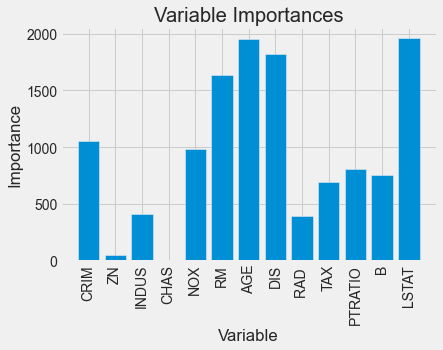

In [102]:
importances= model_light_final.feature_importances_
feature_list = data_train.drop(columns = "MEDV").columns

%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

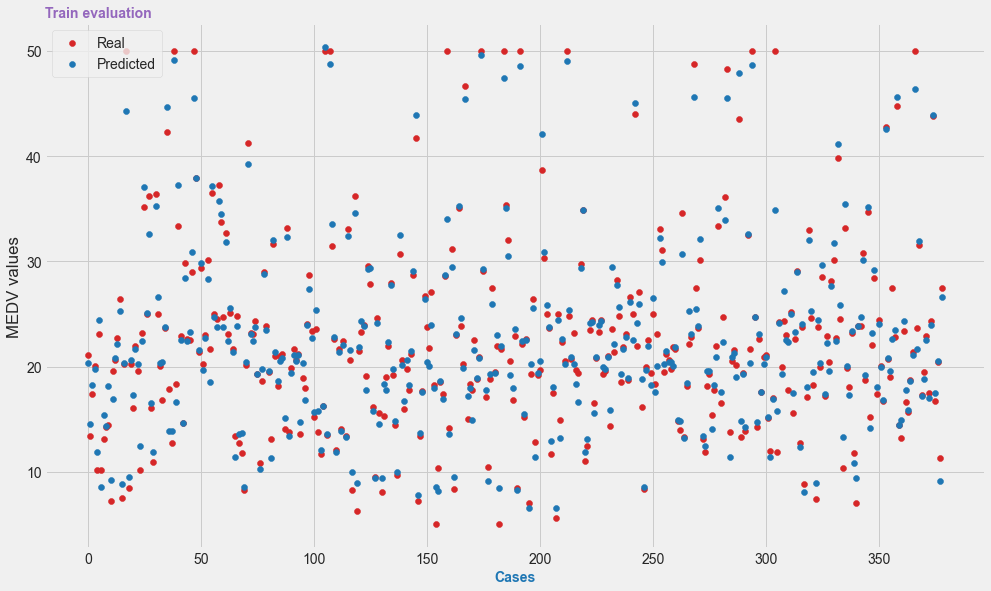

In [103]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 9))


x_axis=list(range(len(y_train)))

ax.scatter(x_axis, y_train, color = 'tab:red', label='Real')
ax.scatter(x_axis, prediction_train, color = 'tab:blue', label='Predicted')
ax.set_xlabel("Cases", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("MEDV values")
ax.set_title('Train evaluation', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

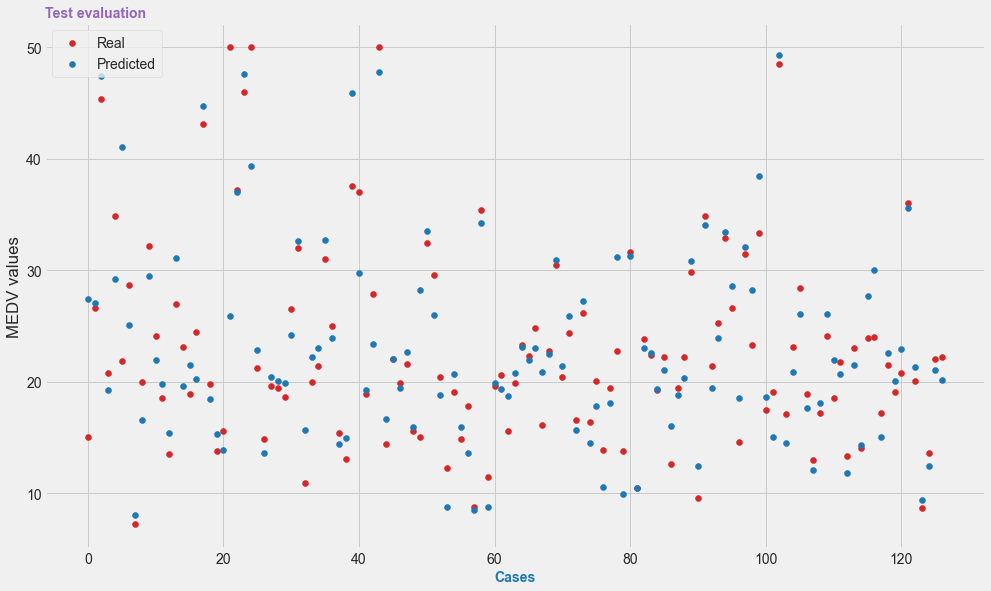

In [104]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 9))


x_axis=list(range(len(y_test)))

ax.scatter(x_axis, y_test, color = 'tab:red', label='Real')
ax.scatter(x_axis, prediction_test, color = 'tab:blue', label='Predicted')
ax.set_xlabel("Cases", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("MEDV values")
ax.set_title('Test evaluation', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

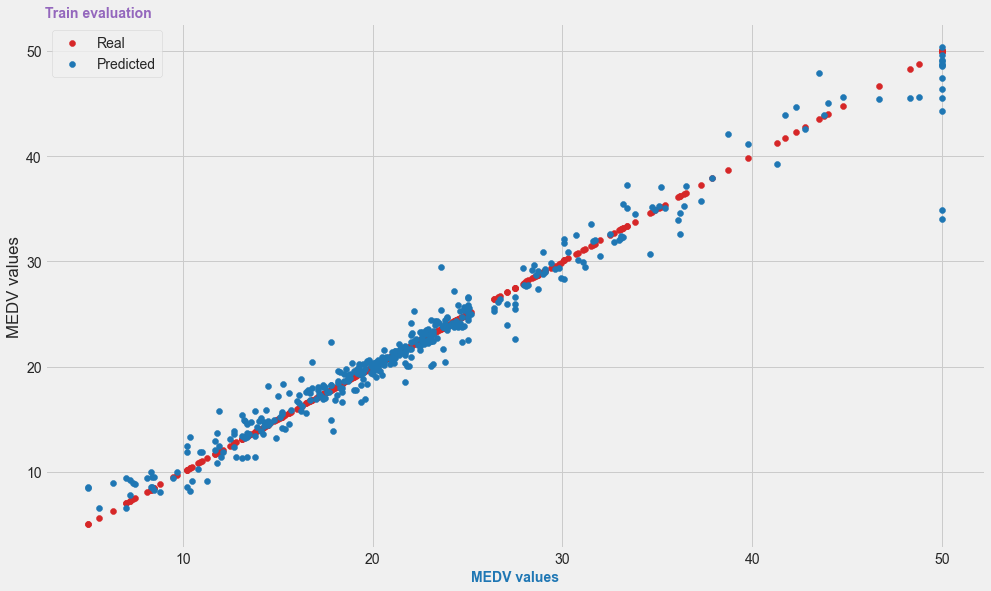

In [105]:
import matplotlib.pyplot as plt  # TRAINING

fig, ax = plt.subplots(figsize=(15, 9))


#x_axis=list(range(len(y_train)))

ax.scatter(y_train, y_train, color = 'tab:red', label='Real')
ax.scatter(y_train, prediction_train, color = 'tab:blue', label='Predicted')
ax.set_xlabel("MEDV values", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("MEDV values")
ax.set_title('Train evaluation', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

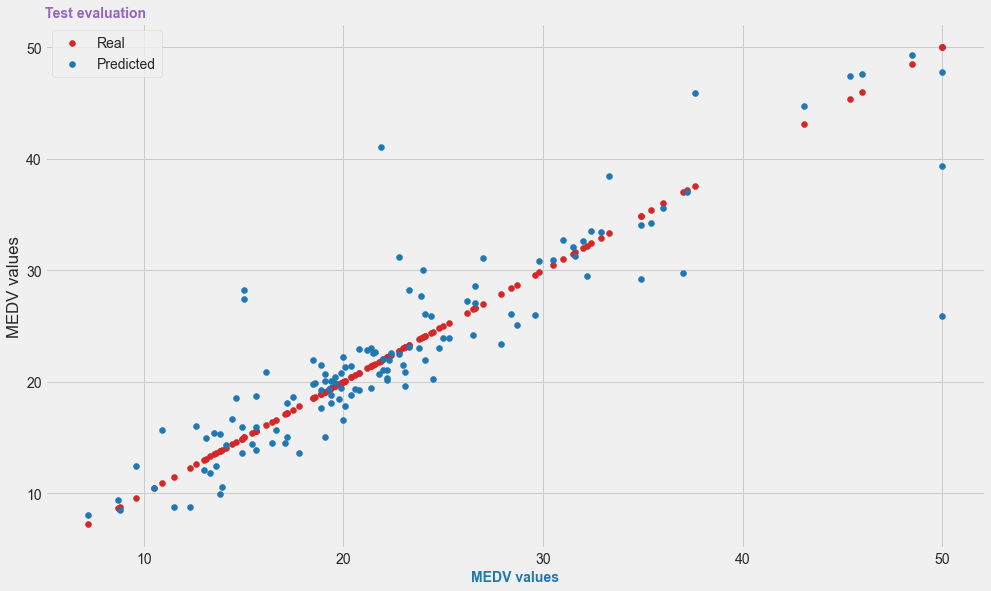

In [106]:
#######  TEST

fig, ax = plt.subplots(figsize=(15, 9))


#x_axis=list(range(len(y_train)))

ax.scatter(y_test, y_test, color = 'tab:red', label='Real')
ax.scatter(y_test, prediction_test, color = 'tab:blue', label='Predicted')
ax.set_xlabel("MEDV values", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("MEDV values")
ax.set_title('Test evaluation', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

<AxesSubplot:xlabel='MEDV', ylabel='Density'>

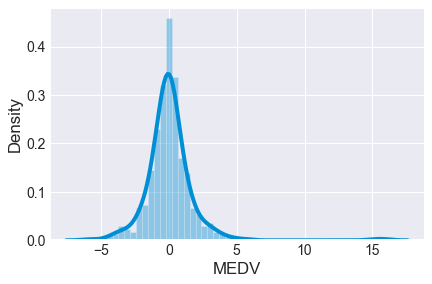

In [107]:
# Error in training
import seaborn as sns
sns.set_style('darkgrid')
sns.distplot(y_train-prediction_train)

<AxesSubplot:xlabel='MEDV', ylabel='Density'>

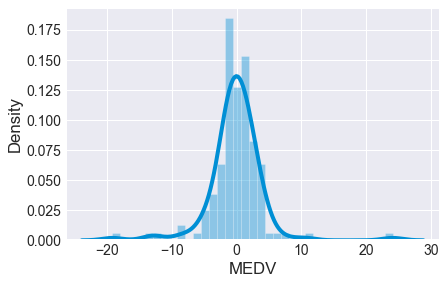

In [108]:
# Error in test

sns.set_style('darkgrid')
sns.distplot(y_test-prediction_test)